## InfluxDB 연결 설정
InfluxDB 연결 정보 설정 및 장비 맵핑

In [19]:
%pip install influxdb_client

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import pytz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import datetime, timedelta
from influxdb_client import InfluxDBClient
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# 한글 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [21]:
# InfluxDB 설정 정보
url = "http://133.186.144.22:8086"
token = "r3Ecro-rJQ82UpyNScnHXYDZ3KaE45AzweCXz6QIv2jeo7eOP4hL4-A9uKvkAVQDg_xavWorGUGZn7MI_sPCwg=="
org = "smoothing"

# Device ID와 위치를 매핑
location_mapping = {
    '24e124126d152919': 'indoor',
    '24e124126d152969': 'bottom_right_corner',
    '24e124128c067999': 'indoor',
    '24e124785c389818': 'bottom_left_corner',
    '24e124785c421885': 'top_right_corner'
}

### 시간대 설정
InfluxDB의 조회 시간이 국제 표준시 UTC로 되어 있기 때문에 한국 표준시로 변경을 해야한다.

따라서 아래 내용에 맞게 한국 표준시로 설정하였다.

In [22]:
# 한국 시간대 설정
korea_tz = pytz.timezone('Asia/Seoul')

# 실행 시점의 날짜를 기준으로 전날의 날짜를 계산
today_kst = datetime.now(korea_tz)
yesterday_kst = today_kst - timedelta(days=1)

# 전날의 시작과 끝 시간을 한국 시간대로 설정
start_time_kst = korea_tz.localize(datetime(yesterday_kst.year, yesterday_kst.month, yesterday_kst.day, 0, 0, 0))
end_time_kst = start_time_kst + timedelta(days=1)

# UTC로 시간 변환
start_time_utc = start_time_kst.astimezone(pytz.utc)
end_time_utc = end_time_kst.astimezone(pytz.utc)

# 확인을 위해 출력
print("Start time in UTC:", start_time_utc)
print("End time in UTC:", end_time_utc)

Start time in UTC: 2024-05-11 15:00:00+00:00
End time in UTC: 2024-05-12 15:00:00+00:00



### 함수 기능
기능 구현에 따른 함수를 사용하기 위한 내용을 아래에 작성하였다.

(구현이 완료되면 구현 마다 각 함수 내용 작성)

In [23]:
def create_client(url, token, org):
    """
    Influx DB 연결 Client를 생성합니다.
    
    :param url: InfluxDB 연결 주소
    :param token: InfluxDB 토큰
    :param org:  InfluxDB 조직
    :return: InfluxDBClient
    """
    return InfluxDBClient(url=url, token=token, org=org)

def query_to_dataframe(client, query, field = "location"):
    """
    구성된 쿼리를 실행하고 전달받은 데이터를 Dataframe으로 만듭니다.
    
    :param field: 기본값 location
    :param client: InfluxDBClient
    :param query: 요청할 쿼리
    :return: DataFrame 
    """
    result = client.query_api().query(query=query)
    results = []
    
    for table in result:
        for record in table.records:
            results.append({
                "time": record.get_time(),
                "value": record.get_value(),
                "place": record.values.get("place"),
                "location": record.values.get(field),
                "device": record.values.get("device")
            })
    
    df = pd.DataFrame(results)
    df['time'] = df['time'].astype(str).str.replace(r'\+00:00$', '', regex=True)
    return df

def save_csv(df, file_pattern, directory):
    
    """
    DataFrame을 CSV로 변환하여 저장합니다.
    
    :param df: DataFrame
    :param file_pattern: 파일 이름 패턴
    :param directory: 저장할 위치
    """
    # 파일 경로를 확인 하고 없다면 생성 합니다.
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    previous_date = datetime.now() - timedelta(days=1)
    filename = f"{directory}{previous_date.strftime(file_pattern)}"
    df.to_csv(filename, index=False)
        
def update_location(df):
    """
    환경 센서 Data에서 Device ID를 확인 하여 'location' 열을 업데이트 합니다.
    
    :param df: 환경 센서 DataFrame
    :return: 'location' 열을 업데이트한 DataFrame
    """
    df['location'] = df['device'].map(location_mapping)
    return df

def merge_data(directory_path):
    """
    CSV 파일들을 하나의 DataFrame으로 병합하고 정렬 합니다.
    
    :param directory_path: 파일 경로 
    :return: 병합된 DataFrame
    """
    # 파일 내의 모든 CSV 파일 목록을 생성
    csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

    # 모든 CSV 파일을 DataFrame으로 읽어와 하나로 병합
    data_frames = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)
        df['time'] = pd.to_datetime(df['time'])
        data_frames.append(df)

    merged_df = pd.concat(data_frames, ignore_index=True)

    # 해당 컬럼들로 재구성
    columns_to_keep = ['time', 'value', 'place', 'location']
    filtered_df = merged_df[columns_to_keep]

    # 'place', 'time' 으로 정렬
    sorted_df = filtered_df.sort_values(['place', 'time'])

    return sorted_df

def df_hourly_calculate(dataframe, change_column_name, calculate):
    """
    DataFrame에서 value를 시간별로 calculate 함수에 따라 계산합니다.
    계산 후 value 컬럼을 지정한 이름으로 변경합니다.
        
    :param dataframe: 계산할 DataFrame
    :param change_column_name: 계산 후 value 컬럼을 지정한 이름으로 변경
    :param calculate: 문자열 형태로 계산할 함수명 ('sum', 'mean', 'diff' 등)
    :return: 시간별 계산된 DataFrame
    """
    # 시간 컬럼이 datetime형태인지 확인하고 설정후 Index로 설정
    if not pd.api.types.is_datetime64_any_dtype(dataframe.index):
        dataframe['time'] = pd.to_datetime(dataframe['time'])
        dataframe.set_index('time', inplace=True)

    # 시간별로 그룹화하여 데이터 계산
    if calculate == 'diff':
        # 시간별로 데이터 변화량 계산
        result = dataframe.resample('H').last()['value'].diff().to_frame(name=change_column_name)
    else:
        # 기타 계산
        result = dataframe.resample('H').agg({'value': calculate}).rename(columns={'value': change_column_name})

    # Null 값 채우기 (forward fill)
    result.fillna(method='bfill', inplace=True)

    # 결과를 소수점 세 자리까지 반올림
    result = result.round(3)

    return result

def merge_dataframes(df_list):
    """
    여러 DataFrame을 병합합니다. 
    
    :param df_list: 병합할 DataFrame 리스트
    :return: 병합된 DataFrame
    """
    merged_df = df_list[0]
    for df in df_list[1:]:
        merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='outer', validate=None)
    return merged_df

def calculate_attendance(dataframe, name):
    # time 컬럼을 datetime 타입으로 변환
    dataframe['time'] = pd.to_datetime(dataframe['time'])

    # 시간대별로 그룹화 (시간, 분, 초까지 모두 고려)
    grouped = dataframe.groupby(['time', 'location'])['value'].sum().unstack().fillna(0)

    # 입장과 퇴장 데이터 분리
    grouped['in'] = grouped.filter(like='_in').sum(axis=1)
    grouped['out'] = grouped.filter(like='_out').sum(axis=1)

    # 순 입장 인원 계산 (재실 인원)
    grouped['net'] = grouped['in'] - grouped['out']

    # 누적 재실 인원 계산
    cumulative = 0  # 초기값 설정
    cumulative_results = []  # 누적 결과를 저장할 리스트
    for net in grouped['net']:
        cumulative += net
        if cumulative < 0:
            cumulative = 0  # 음수는 0으로 처리
        cumulative_results.append(cumulative)

    grouped[name] = cumulative_results

    final_result = grouped[[name]]
    final_result.index = grouped.index.get_level_values('time')

    # 결과를 소수점 세 자리까지 반올림
    final_result = final_result.round(3)

    return final_result

def separation_dataframe(dataframe):
    
    # 'location' 별로 데이터 프레임 그룹화
    grouped = dataframe.groupby('location')

    # 딕셔너리에 데이터 프레임 저장
    dataframes = {location.replace(" ", "_").lower(): df for location, df in grouped}

    return dataframes

def visualize_outliers(df, column):

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=column)
    plt.title('박스 플롯')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=column, kde=True)
    plt.title('데이터 분포')

    plt.tight_layout()
    plt.show()

### 쿼리를 통한 데이터 수집
InfluxDB에 연결하여 해당 쿼리들을 통해 아래 내용의 데이터를 수집한다.

전력(W), 전력 사용량(Kwh), 온도, CO2, 조도, 습도, 이동 감지 카운터

In [24]:
# DB 연결 및 쿼리 실행
client = create_client(url, token, org)

# 전력(W) 조회(class a : main) Flux 쿼리
query_power_total_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["location"] == "main")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력 사용량 조회(class a : main) Flux 쿼리
query_power_usage_total_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "kwh")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["description"] == "sum")
  |> filter(fn: (r) => r["location"] == "main")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력(W) 조회(class a : device) Flux 쿼리
query_power_device_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["location"] != "main" and r["location"] != "outdoor_unit_room_light")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력 사용량 조회(class a : device) Flux 쿼리
query_power_usage_device_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "kwh")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["description"] == "sum")
  |> filter(fn: (r) => r["location"] != "main" and r["location"] != "outdoor_unit_room_light")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력(W) 조회 (class a : 콘센트)
query_power_socket_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "office")
  |> filter(fn: (r) => r["location"] == "class_a_floor_heating_1" or r["location"] == "class_a_floor_heating_2")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 전력 사용량 조회 (class a : 콘센트)
query_power_usage_socket_data = f'''
import "experimental"
from(bucket: "powermetrics_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["phase"] == "kwh")
  |> filter(fn: (r) => r["place"] == "office")
  |> filter(fn: (r) => r["location"] == "class_a_floor_heating_1" or r["location"] == "class_a_floor_heating_2")
  |> filter(fn: (r) => r["description"] == "sum")
  |> aggregateWindow(every: 1m, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 온도 조회 Flux 쿼리
query_temperature_data = f'''
import "experimental"
from(bucket: "environmentalsensors_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["measurement"] == "temperature")
  |> filter(fn: (r) => r["place"] == "class_a")
  |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 이산화탄소 조회 Flux 쿼리
query_co2_data = f'''
import "experimental"
from(bucket: "environmentalsensors_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["measurement"] == "co2")
  |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 조도 조회 Flux 쿼리
query_illumination_data = f'''
import "experimental"
from(bucket: "environmentalsensors_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["measurement"] == "illumination")
  |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 습도 조회 Flux 쿼리
query_humidity_data = f'''
import "experimental"
from(bucket: "environmentalsensors_data")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["measurement"] == "humidity")
  |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# 이동 감지 카운터 조회 Flux 쿼리
query_counter_data = f'''
import "experimental"
from(bucket: "milesight")
  |> range(start: {start_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')}, stop: {end_time_utc.strftime('%Y-%m-%dT%H:%M:%SZ')})
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["_field"] == "line_periodic_data_1_out" or r["_field"] == "line_periodic_data_1_in")
  |> aggregateWindow(every: 1h, fn: last, createEmpty: false)
  |> map(fn: (r) => ({{r with _time: experimental.addDuration(d: 9h, to: r._time)}}))
  |> keep(columns: ["_time", "_value", "place", "_field", "device"])
'''

# 전력 CSV 생성(main)
df_power = query_to_dataframe(client, query_power_total_data)
print(df_power.head(2))
save_csv(df_power, "%m_%d_power_total_data.csv", "all_data/power/total/")

# 전력 사용량 CSV 생성(main)
df_power_usage = query_to_dataframe(client, query_power_usage_total_data)
save_csv(df_power_usage, "%m_%d_power_usage_total_data.csv", "all_data/power_usage/total/")
print(df_power_usage.head(2))

# 전력 CSV 생성(device)
df_power_device = query_to_dataframe(client, query_power_device_data)
print(df_power_device.head(2))
save_csv(df_power_device, "%m_%d_power_device_data.csv", "all_data/power/device/")

# 전력 사용량 CSV 생성(device)
df_power_usage_device = query_to_dataframe(client, query_power_usage_device_data)
save_csv(df_power_usage_device, "%m_%d_power_usage_device_data.csv", "all_data/power_usage/device/")
print(df_power_usage_device.head(2))

# 전력 CSV 생성(콘센트)
df_power_socket = query_to_dataframe(client, query_power_socket_data)
print(df_power_socket.head(2))
save_csv(df_power_socket, "%m_%d_power_socket_data.csv", "all_data/power/socket/")

# 전력 사용량 CSV 생성(콘센트)
df_power_usage_socket = query_to_dataframe(client, query_power_usage_socket_data)
print(df_power_usage_socket.head(2))
save_csv(df_power_usage_socket, "%m_%d_power_usage_socket_data.csv", "all_data/power_usage/socket/")

# 온도 CSV 생성
df_temperature = query_to_dataframe(client, query_temperature_data)
df_temperature_fix = update_location(df_temperature)
print(df_temperature_fix.head(2))
save_csv(df_temperature_fix, "%m_%d_temperature_data.csv", "all_data/temperature/")

# co2 CSV 생성
df_co2 = query_to_dataframe(client, query_co2_data)
df_co2_fix = update_location(df_co2)
print(df_co2_fix.head(2))
save_csv(df_co2_fix, "%m_%d_co2_data.csv", "all_data/co2/")

# 조도 CSV 생성
df_illumination = query_to_dataframe(client, query_illumination_data)
update_location(df_illumination)
print(df_illumination.head(2))
save_csv(df_illumination, "%m_%d_illumination_data.csv", "all_data/illumination/")

# 습도 CSV 생성
df_humidity = query_to_dataframe(client, query_humidity_data)
update_location(df_humidity)
print(df_humidity.head(2))
save_csv(df_humidity, "%m_%d_humidity_data.csv", "all_data/humidity/")

# 이동 감지 카운터 CSV 생성
df_counter = query_to_dataframe(client, query_counter_data, "_field")
print(df_counter.head(2))
save_csv(df_counter, "%m_%d_counter_data.csv", "all_data/counter/total/")

# 연결 Client 종료
client.close()

                  time   value    place location     device
0  2024-05-12 00:01:00  1409.0  class_a     main  gems-3500
1  2024-05-12 00:02:00  1455.0  class_a     main  gems-3500
                  time   value    place location     device
0  2024-05-12 00:01:00  1043.2  class_a     main  gems-3500
1  2024-05-12 00:02:00  1043.2  class_a     main  gems-3500
                  time  value    place        location     device
0  2024-05-12 00:01:00   93.0  class_a  ac_indoor_unit  gems-3500
1  2024-05-12 00:02:00   91.0  class_a  ac_indoor_unit  gems-3500
                  time  value    place        location     device
0  2024-05-12 00:01:00   53.4  class_a  ac_indoor_unit  gems-3500
1  2024-05-12 00:02:00   53.4  class_a  ac_indoor_unit  gems-3500
                  time  value   place                 location     device
0  2024-05-12 00:01:00  141.0  office  class_a_floor_heating_1  gems-3500
1  2024-05-12 00:02:00  141.0  office  class_a_floor_heating_1  gems-3500
                  time

### CSV 병합
파일 경로를 통해 집계된 CSV를 병합하고 각각의 Dataframe으로 만든다.

In [25]:
power_path = 'all_data/power/total'
power_total_df = merge_data(power_path)
print(power_total_df.head(2), "\n")

power_usage_path = 'all_data/power_usage/total'
power_usage_total_df = merge_data(power_usage_path)
print(power_usage_total_df.head(2), "\n")

power_device_path = 'all_data/power/device'
power_device_df = merge_data(power_device_path)
print(power_device_df.head(2), "\n")
power_dataframes = separation_dataframe(power_device_df)

power_usage_device_path = 'all_data/power_usage/device'
power_usage_device_df = merge_data(power_usage_device_path)
print(power_usage_device_df.head(2), "\n")
power_usage_dataframes = separation_dataframe(power_usage_device_df)

power_socket_path = 'all_data/power/socket'
power_socket_df = merge_data(power_socket_path)
power_socket_df = power_socket_df.groupby(['time', 'place'])['value'].mean().reset_index()
print(power_socket_df.head(2), "\n")

power_usage_socket_path = 'all_data/power_usage/socket'
power_usage_socket_df = merge_data(power_usage_socket_path)
power_usage_socket_df = power_usage_socket_df.groupby(['time', 'place'])['value'].mean().reset_index()
print(power_usage_socket_df.head(2), "\n")

temperature_path = 'all_data/temperature'
temperature_total_df = merge_data(temperature_path)
print(temperature_total_df.head(2), "\n")

co2_path = 'all_data/co2'
co2_total_df = merge_data(co2_path)
print(co2_total_df.head(2), "\n")

illumination_path = 'all_data/illumination'
illumination_total_df = merge_data(illumination_path)
print(illumination_total_df.head(2), "\n")

humidity_path = 'all_data/humidity'
humidity_total_df = merge_data(humidity_path)
print(humidity_total_df.head(2), "\n")

counter_path = 'all_data/counter/total'
counter_total_df = merge_data(counter_path)
print(counter_total_df.head(2), "\n")

                     time  value    place location
33052 2024-04-15 00:01:00  153.0  class_a     main
33053 2024-04-15 00:02:00  151.0  class_a     main 

                     time  value    place location
20041 2024-04-15 00:01:00  264.7  class_a     main
20042 2024-04-15 00:02:00  264.7  class_a     main 

                     time  value    place         location
56063 2024-04-15 00:01:00   23.0  class_a   ac_indoor_unit
57499 2024-04-15 00:01:00  117.0  class_a  ac_outdoor_unit 

                     time  value    place         location
25824 2024-04-15 00:01:00   16.1  class_a   ac_indoor_unit
27249 2024-04-15 00:01:00  235.0  class_a  ac_outdoor_unit 

                 time   place  value
0 2024-04-15 00:01:00  office   23.5
1 2024-04-15 00:02:00  office   23.5 

                 time   place  value
0 2024-04-15 00:01:00  office   74.4
1 2024-04-15 00:02:00  office   74.4 

                    time      value    place             location
1613 2024-04-15 01:00:00  23.673333  cla

### 데이터 집계 

In [26]:
temperature_total_df = df_hourly_calculate(temperature_total_df, "average_temperature(°C)", "mean")
humidity_total_df = df_hourly_calculate(humidity_total_df, "average_humidity(%)", "mean")
co2_total_df = df_hourly_calculate(co2_total_df, "average_co2(ppm)", "mean")
illumination_total_df = df_hourly_calculate(illumination_total_df, "average_illumination(lux)", "mean")
counter_total_df = calculate_attendance(counter_total_df, "people_in_room")

/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='bfill', inplace=True)
/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='bfill', inplace=True)
/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='bfill', inplace=True)
/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='bfill', inplace=True)


In [27]:
temperature_total_df['average_temperature(°C)'] = np.log1p(temperature_total_df['average_temperature(°C)'])
humidity_total_df['average_humidity(%)'] = np.log1p(humidity_total_df['average_humidity(%)'])
co2_total_df['average_co2(ppm)'] = np.log1p(co2_total_df['average_co2(ppm)'])
illumination_total_df['average_illumination(lux)'] = np.log1p(illumination_total_df['average_illumination(lux)'])
counter_total_df['people_in_room'] = np.log1p(counter_total_df['people_in_room'])

### 이상치 확인
Displot과 Boxplot을 사용하여 이상치를 확인한다.

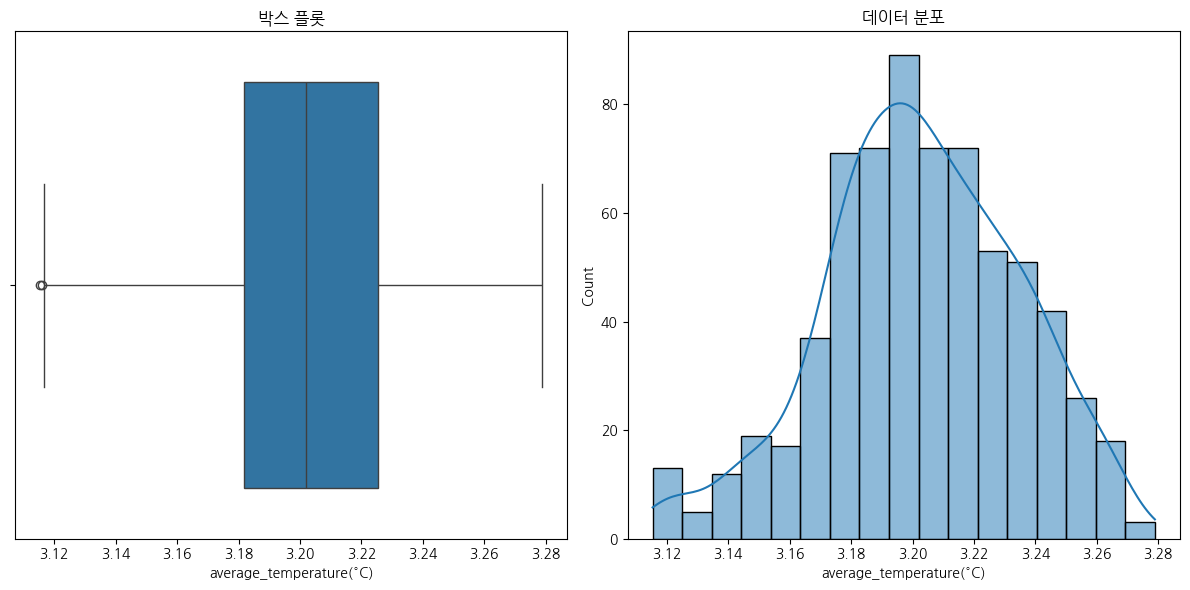

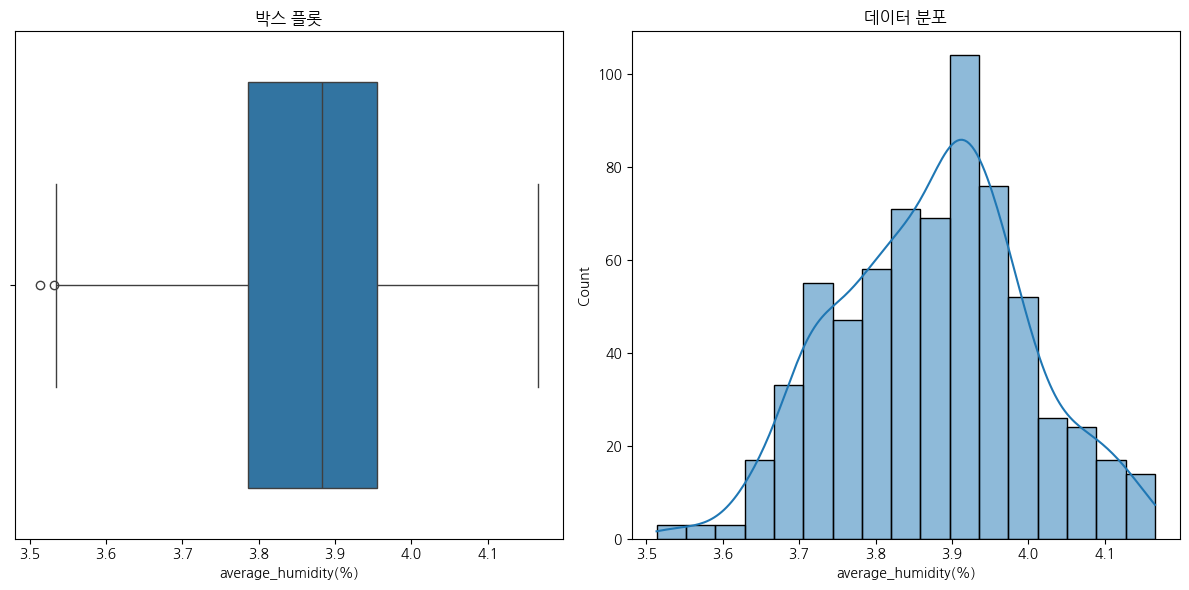

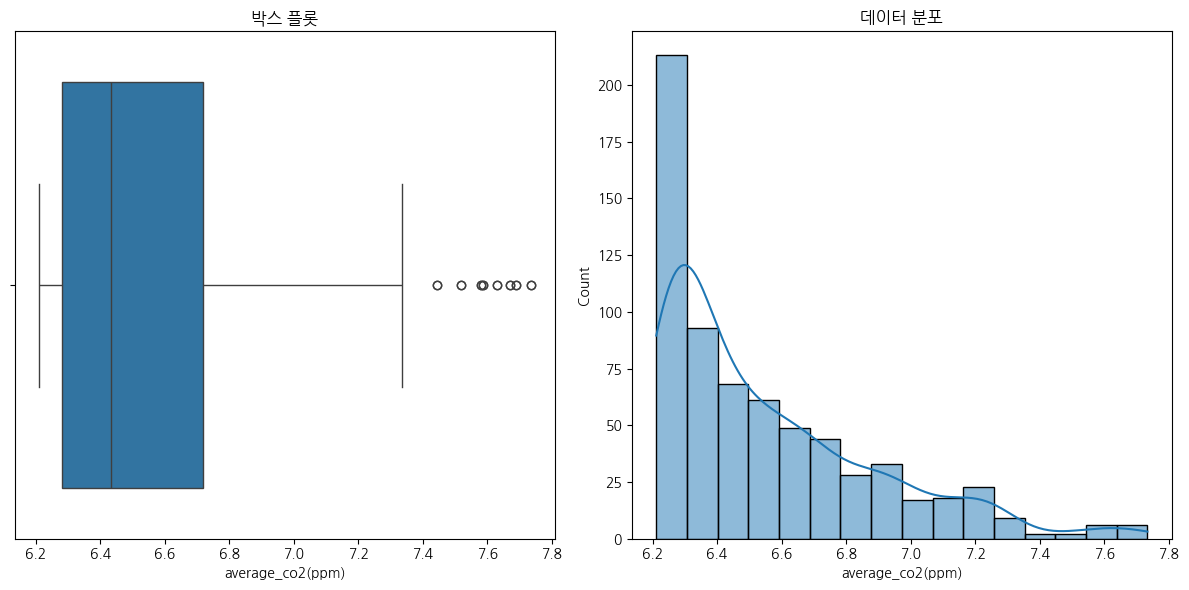

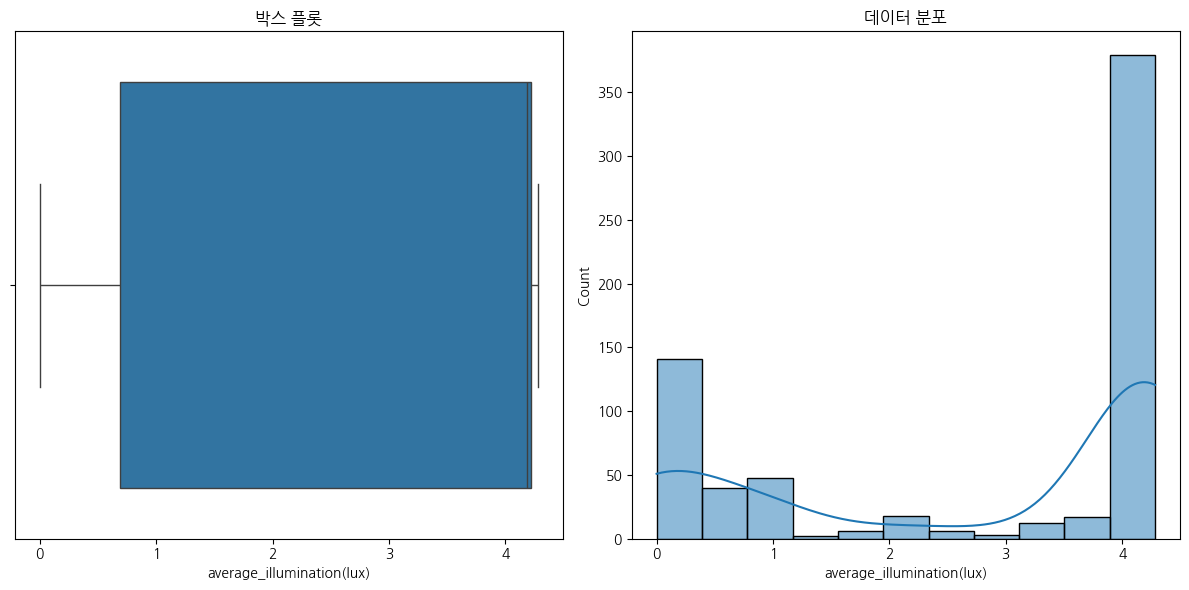

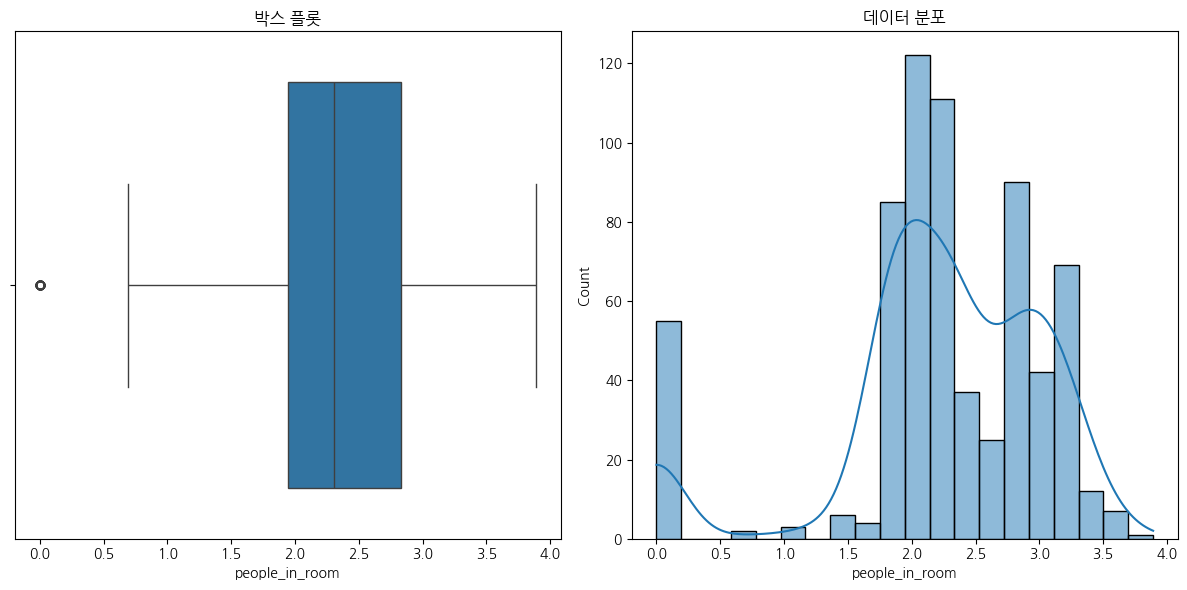

In [28]:
visualize_outliers(temperature_total_df, "average_temperature(°C)")
visualize_outliers(humidity_total_df, "average_humidity(%)")
visualize_outliers(co2_total_df, "average_co2(ppm)")
visualize_outliers(illumination_total_df, "average_illumination(lux)")
visualize_outliers(counter_total_df, "people_in_room")

### 이상치 제거
확인된 이상치를 Isolation Forest를 사용하여 제거한다.

이상치를 제거후 Dispolt과 Boxplot을 사용하여 다시 확인한다.

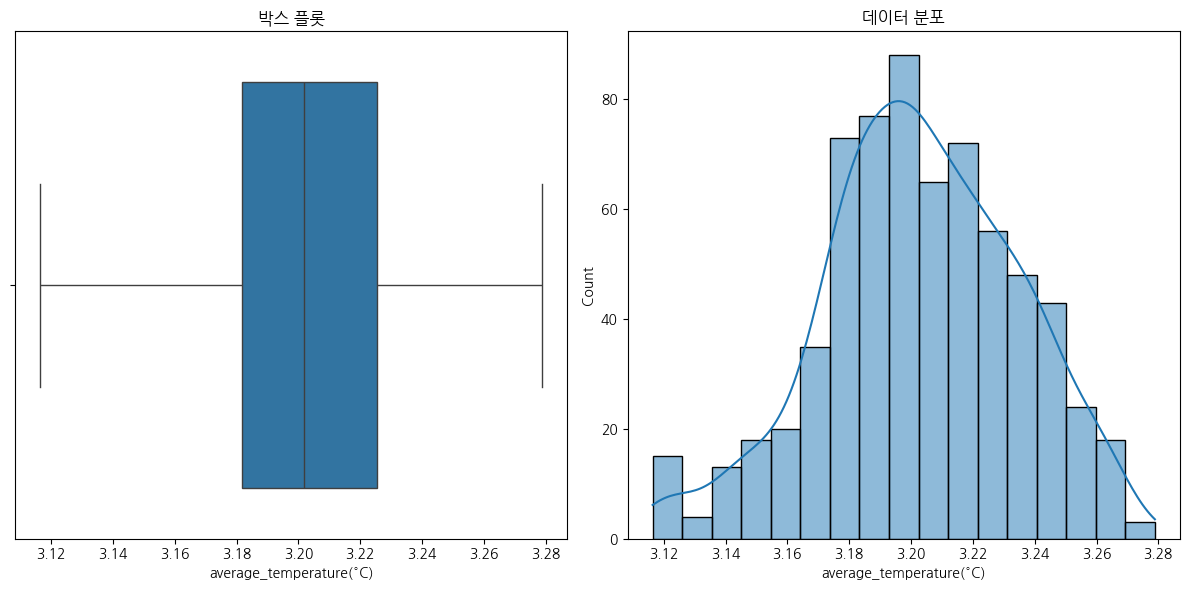

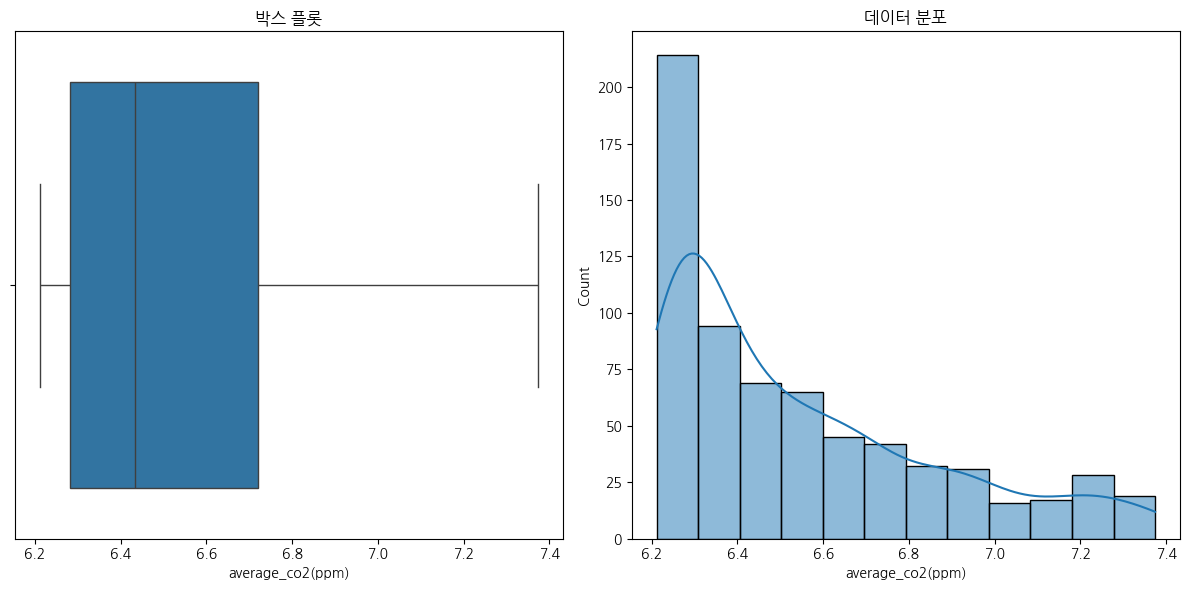

In [29]:
def replace_iqr_outliers(df):
    cleaned_df = df.copy()

    # 모든 수치형 컬럼에 대해 이상치 대체 수행
    for column in cleaned_df.select_dtypes(include=['float64', 'int64']):
        Q1 = cleaned_df[column].quantile(0.25)
        Q3 = cleaned_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 하한값 또는 상한값으로 대체
        cleaned_df[column] = np.where(cleaned_df[column] < lower_bound, lower_bound, cleaned_df[column])
        cleaned_df[column] = np.where(cleaned_df[column] > upper_bound, upper_bound, cleaned_df[column])

    return cleaned_df
temperature_total_df = replace_iqr_outliers(temperature_total_df)
co2_total_df = replace_iqr_outliers(co2_total_df)
"average_co2(ppm)"
visualize_outliers(temperature_total_df, 'average_temperature(°C)')
visualize_outliers(co2_total_df, "average_co2(ppm)")

데이터 병합 (csv)

In [30]:
# 데이터프레임 병합
final_environment_data_df = merge_dataframes([counter_total_df, temperature_total_df, humidity_total_df, co2_total_df, illumination_total_df])

# 결과 확인
print(final_environment_data_df)

# 인덱스를 일반 컬럼으로 변경
final_environment_data_df = final_environment_data_df.reset_index()

# CSV 파일로 저장
final_environment_data_df.to_csv('all_data/all_final_df/class_a_environmental_sensor.csv', index=False)

# 널 값 개수 출력
print(final_environment_data_df.isnull().sum())

                     people_in_room  average_temperature(°C)  \
time                                                           
2024-04-15 01:00:00        0.000000                 3.215711   
2024-04-15 02:00:00        0.000000                 3.190723   
2024-04-15 03:00:00        0.000000                 3.187922   
2024-04-15 04:00:00        0.000000                 3.184160   
2024-04-15 05:00:00        0.000000                 3.175927   
...                             ...                      ...   
2024-05-12 20:00:00        2.708050                 3.175634   
2024-05-12 21:00:00        2.302585                 3.168172   
2024-05-12 22:00:00        2.772589                 3.169307   
2024-05-12 23:00:00        2.639057                 3.167583   
2024-05-13 00:00:00        2.639057                 3.163913   

                     average_humidity(%)  average_co2(ppm)  \
time                                                         
2024-04-15 01:00:00             3.889900   

데이터 집계

In [31]:
# 전체 전력/전력량
power_total_df = df_hourly_calculate(power_total_df, "total_power(Wh)", "sum")
power_usage_total_df = df_hourly_calculate(power_usage_total_df, 'total_power_usage(Kwh)', 'diff')

# 실내기 전력 / 전력량
power_ac_in_df = df_hourly_calculate(power_dataframes['ac_indoor_unit'], "ac_in_power(Wh)", "sum")
power_usage_ac_in_df = df_hourly_calculate(power_usage_dataframes['ac_indoor_unit'], "ac_in_power(Kwh)", "diff")

# 실외기 전력/전력량
power_ac_out_df = df_hourly_calculate(power_dataframes['ac_outdoor_unit'], "ac_out_power(Wh)", "sum")
power_usage_ac_out_df = df_hourly_calculate(power_usage_dataframes['ac_outdoor_unit'], "ac_out_power(Kwh)", "diff")

# 자동문 전력/전력량
power_automatic_door_df = df_hourly_calculate(power_dataframes['automatic_door'], "automatic_door_power(Wh)", "sum")
power_usage_automatic_door_df = df_hourly_calculate(power_usage_dataframes['automatic_door'], "automatic_door_power(Kwh)", "diff")

# 콘센트 전력/전력량
power_socket_df = df_hourly_calculate(power_socket_df, "socket_power(Wh)", "sum")
power_usage_socket_df = df_hourly_calculate(power_usage_socket_df, "socket_power(Kwh)", "diff")

/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='bfill', inplace=True)
/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='bfill', inplace=True)
/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='bfill', inplace=True)
/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='bfill', inplace=True)
/tmp/ipykernel_26810/3674487078.py:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will rai

In [32]:
# 전체 전력 데이터에 로그 스케일 적용
power_total_df['total_power(Wh)'] = np.log1p(power_total_df['total_power(Wh)'])
power_usage_total_df['total_power_usage(Kwh)'] = np.log1p(power_usage_total_df['total_power_usage(Kwh)'])

# 실내기 전력 데이터에 로그 스케일 적용
power_ac_in_df['ac_in_power(Wh)'] = np.log1p(power_ac_in_df['ac_in_power(Wh)'])
power_usage_ac_in_df['ac_in_power(Kwh)'] = np.log1p(power_usage_ac_in_df['ac_in_power(Kwh)'])

# 실외기 전력 데이터에 로그 스케일 적용
power_ac_out_df['ac_out_power(Wh)'] = np.log1p(power_ac_out_df['ac_out_power(Wh)'])
power_usage_ac_out_df['ac_out_power(Kwh)'] = np.log1p(power_usage_ac_out_df['ac_out_power(Kwh)'])

# 자동문 전력 데이터에 로그 스케일 적용
power_automatic_door_df['automatic_door_power(Wh)'] = np.log1p(power_automatic_door_df['automatic_door_power(Wh)'])
power_usage_automatic_door_df['automatic_door_power(Kwh)'] = np.log1p(power_usage_automatic_door_df['automatic_door_power(Kwh)'])

# 콘센트 전력 데이터에 로그 스케일 적용
power_socket_df['socket_power(Wh)'] = np.log1p(power_socket_df['socket_power(Wh)'])
power_usage_socket_df['socket_power(Kwh)'] = np.log1p(power_usage_socket_df['socket_power(Kwh)'])

이상치 확인

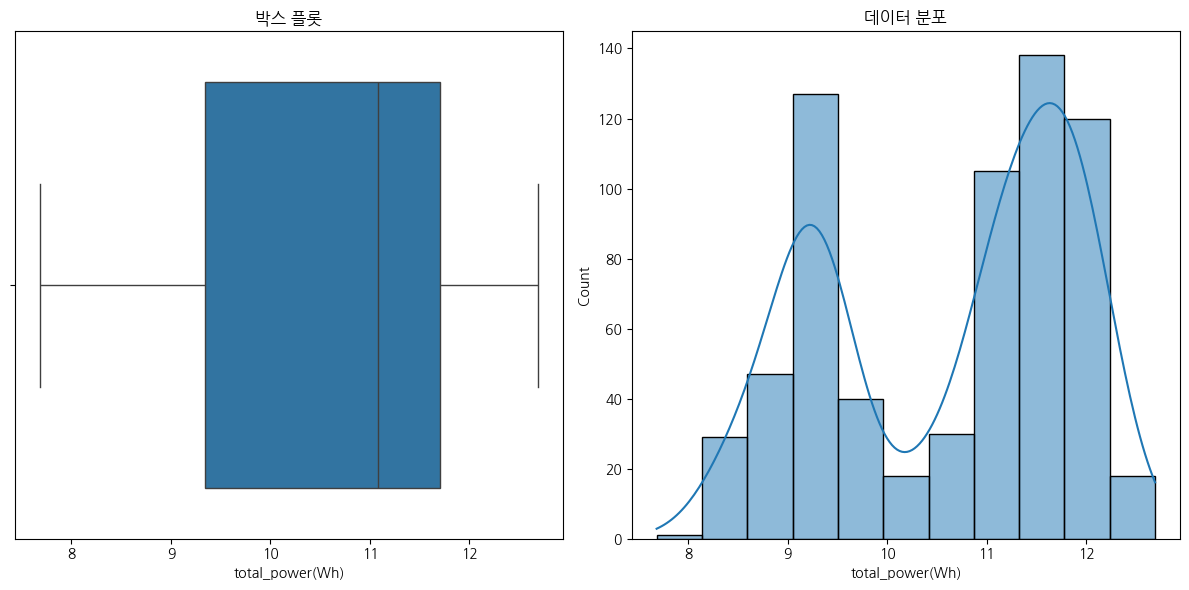

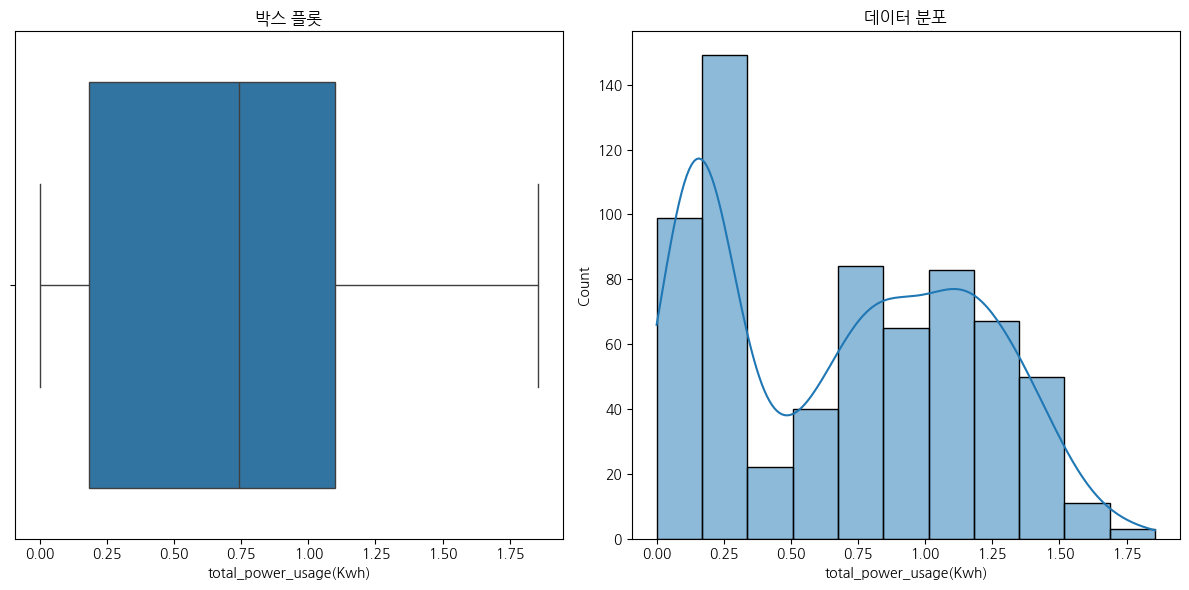

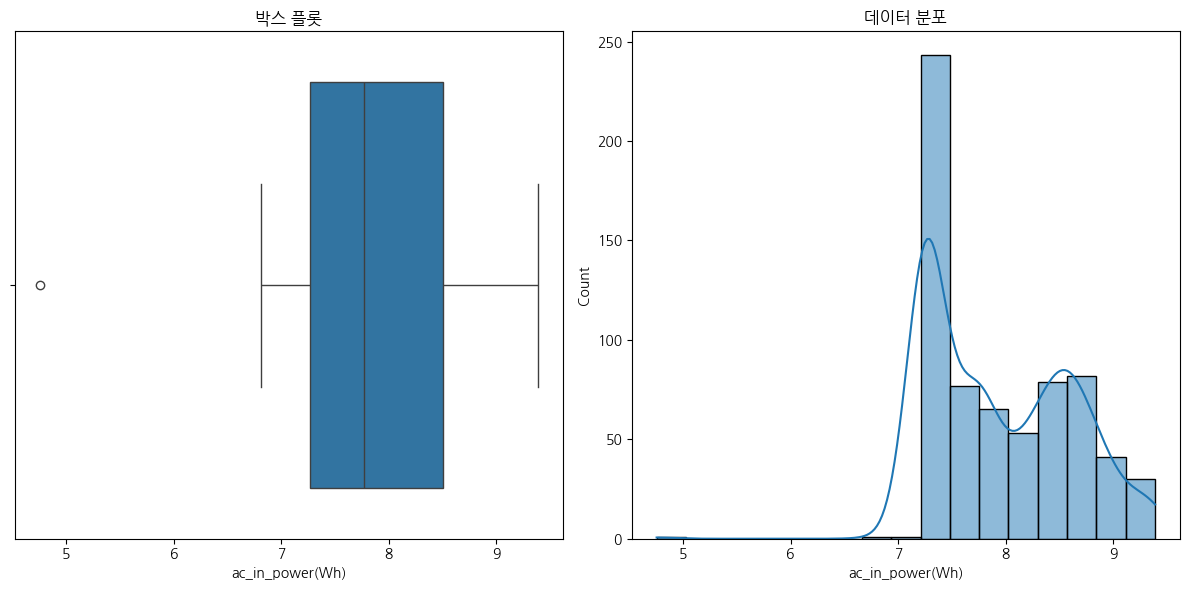

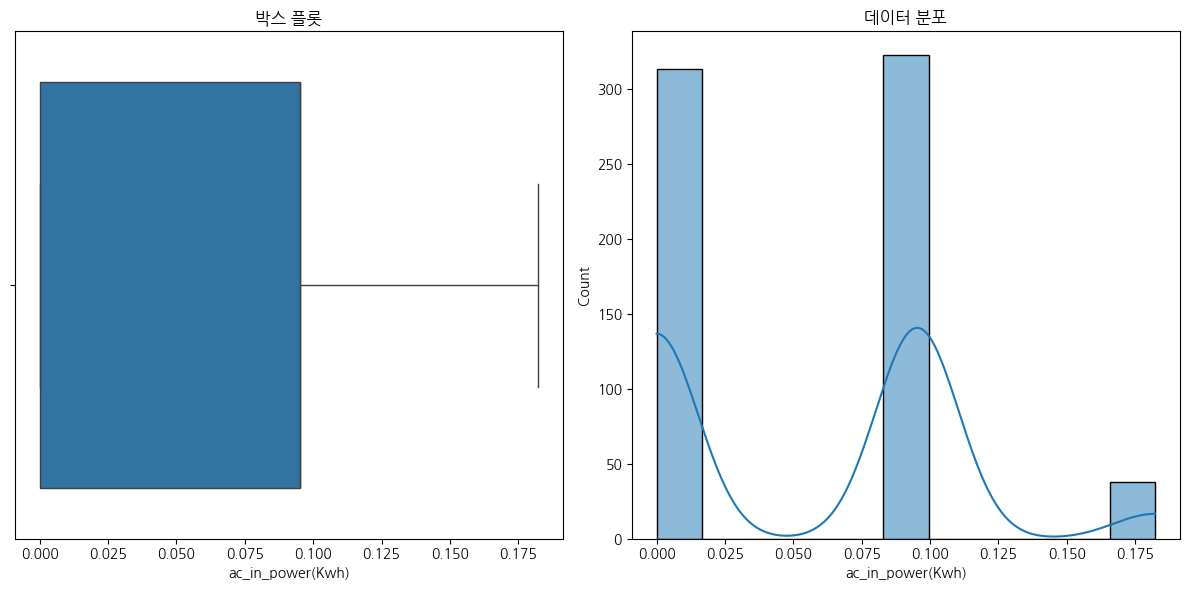

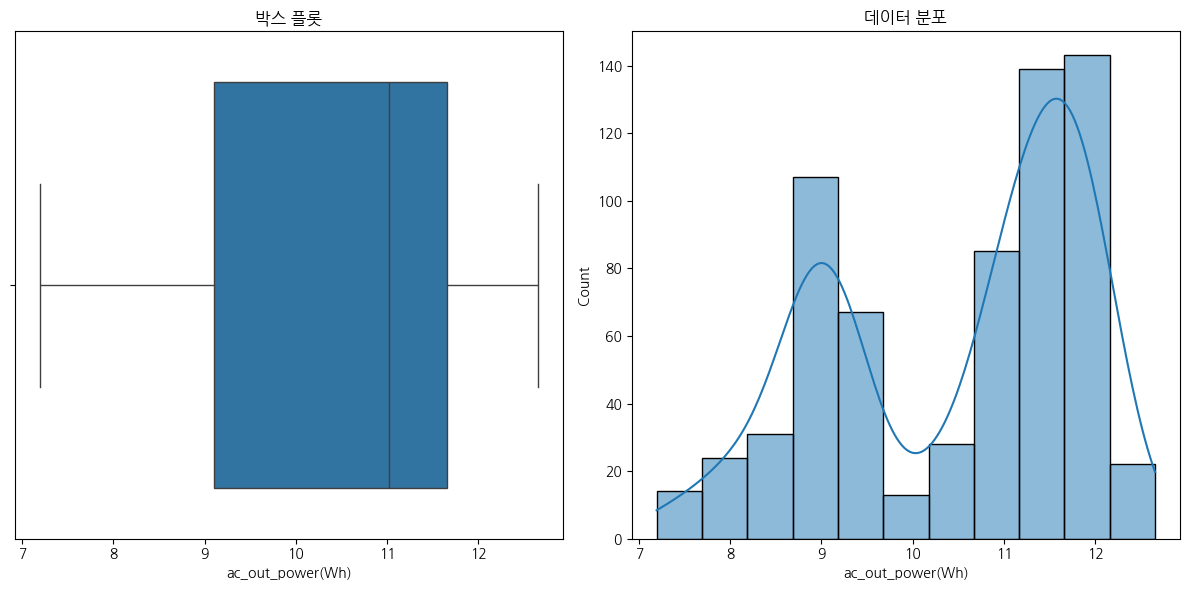

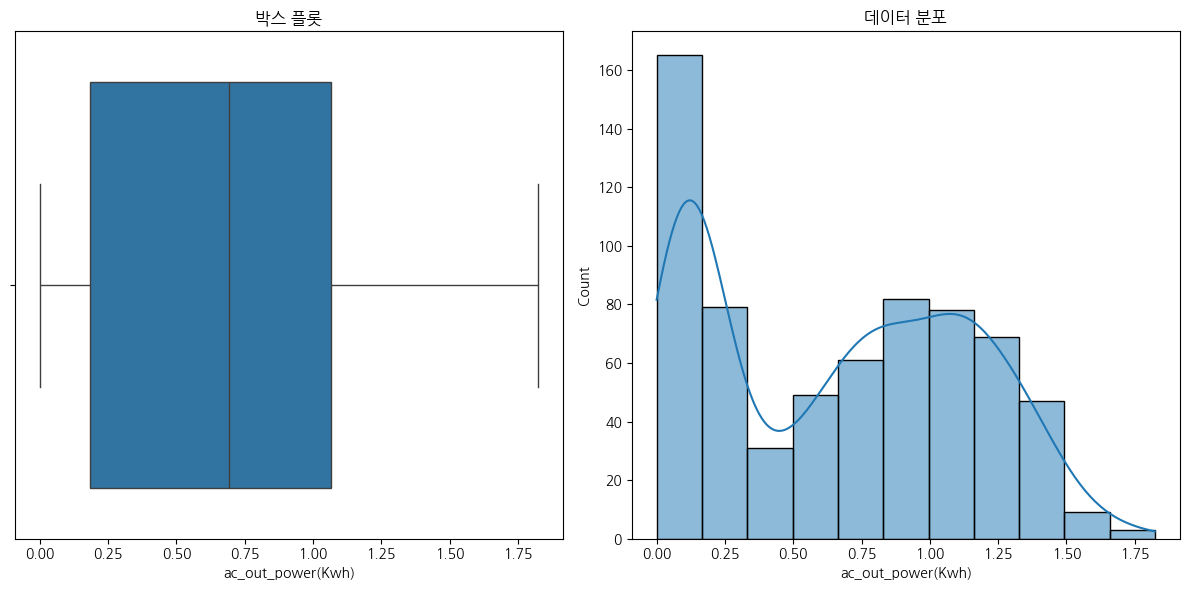

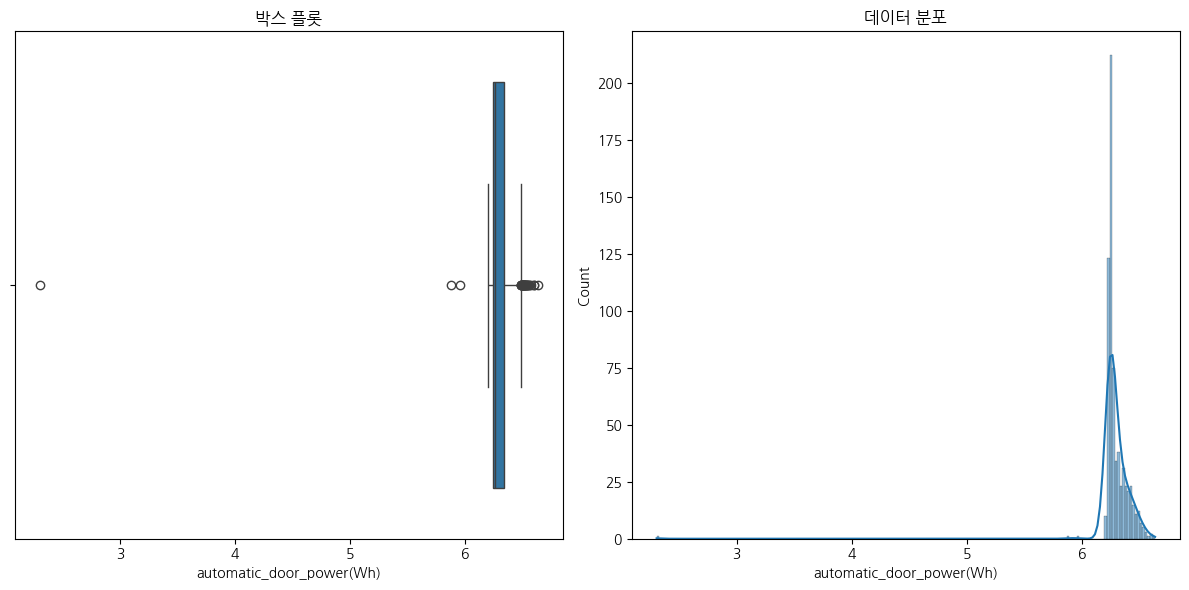

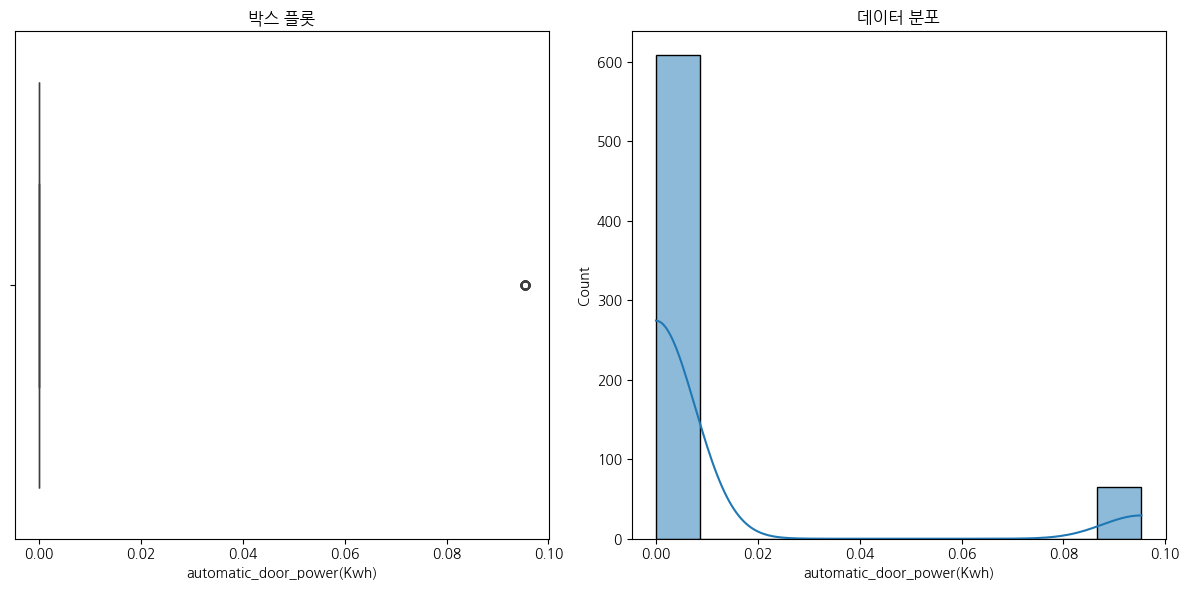

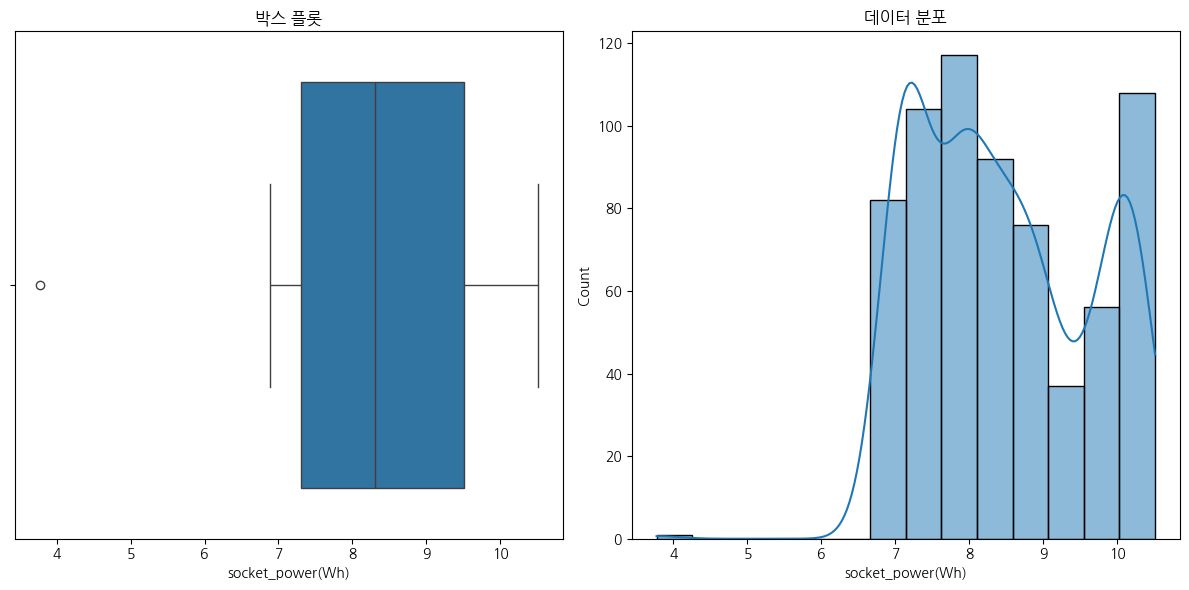

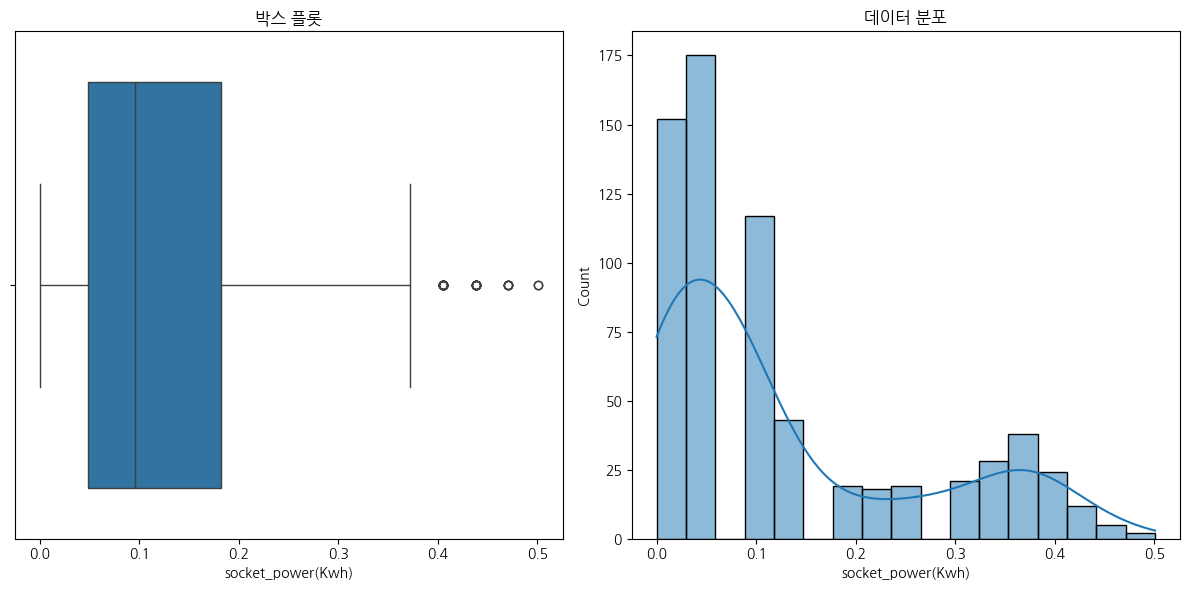

In [33]:
visualize_outliers(power_total_df, "total_power(Wh)")
visualize_outliers(power_usage_total_df, "total_power_usage(Kwh)")
visualize_outliers(power_ac_in_df, "ac_in_power(Wh)")
visualize_outliers(power_usage_ac_in_df, "ac_in_power(Kwh)")
visualize_outliers(power_ac_out_df, "ac_out_power(Wh)")
visualize_outliers(power_usage_ac_out_df, "ac_out_power(Kwh)")
visualize_outliers(power_automatic_door_df, "automatic_door_power(Wh)")
visualize_outliers(power_usage_automatic_door_df, "automatic_door_power(Kwh)")
visualize_outliers(power_socket_df, "socket_power(Wh)")
visualize_outliers(power_usage_socket_df, "socket_power(Kwh)")

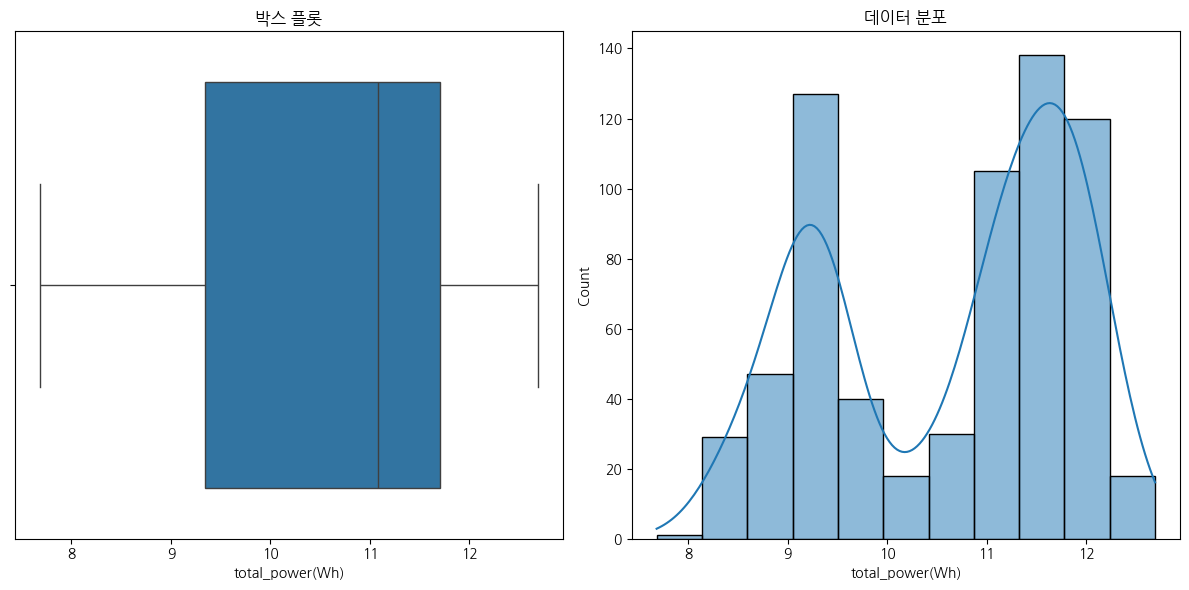

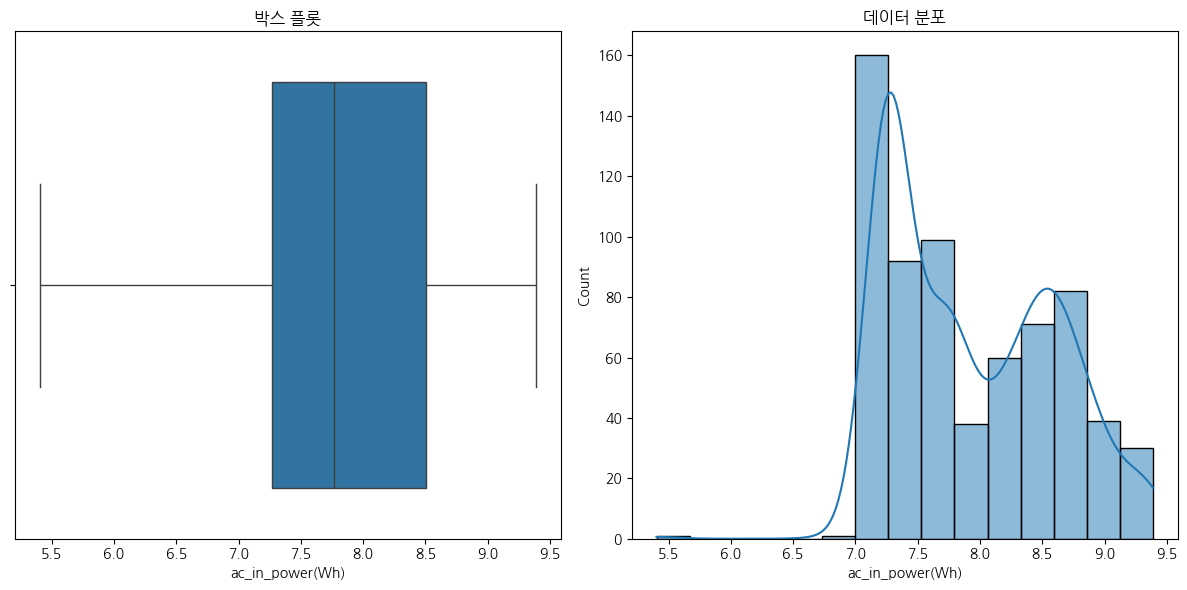

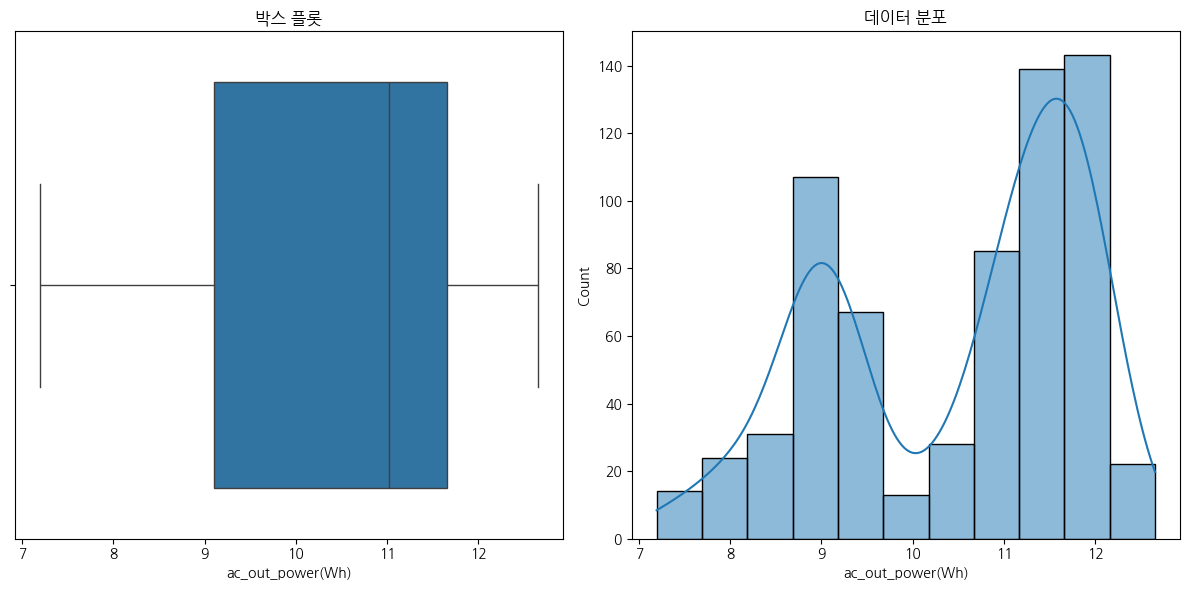

In [34]:
power_total_df = replace_iqr_outliers(power_total_df)
power_ac_in_df = replace_iqr_outliers(power_ac_in_df)
power_ac_out_df = replace_iqr_outliers(power_ac_out_df)
visualize_outliers(power_total_df, "total_power(Wh)")
visualize_outliers(power_ac_in_df, "ac_in_power(Wh)")
visualize_outliers(power_ac_out_df, "ac_out_power(Wh)")

데이터 병합 csv

In [35]:
final_main_power_data_df = merge_dataframes([power_total_df])
print(final_main_power_data_df)
final_main_power_data_df = final_main_power_data_df.reset_index()
final_main_power_data_df.to_csv('all_data/all_final_df/class_a_main_power_sensor.csv', index=False)

final_main_power_usage_data_df = merge_dataframes([power_usage_total_df])
print(final_main_power_usage_data_df)
final_main_power_usage_data_df = final_main_power_usage_data_df.reset_index()
final_main_power_usage_data_df.to_csv('all_data/all_final_df/class_a_main_power_usage_sensor.csv', index=False)

final_device_power_data_df = merge_dataframes([power_ac_in_df, power_ac_out_df, power_automatic_door_df, power_socket_df])
print(final_device_power_data_df)
final_power_data_df = final_device_power_data_df.reset_index()
final_power_data_df.to_csv('all_data/all_final_df/class_a_device_power_sensor.csv', index=False)

final_device_power_usage_df = merge_dataframes([power_usage_ac_in_df, power_usage_ac_out_df, power_usage_automatic_door_df, power_usage_socket_df])
print(final_device_power_usage_df)
final_power_usage_df = final_device_power_usage_df.reset_index()
final_power_usage_df.to_csv('all_data/all_final_df/class_a_device_power_usage_sensor.csv', index=False)

                     total_power(Wh)
time                                
2024-04-15 00:00:00         8.438799
2024-04-15 01:00:00         9.425452
2024-04-15 02:00:00         9.262743
2024-04-15 03:00:00         8.841593
2024-04-15 04:00:00         9.402365
...                              ...
2024-05-12 20:00:00        11.719988
2024-05-12 21:00:00        11.569911
2024-05-12 22:00:00        11.484176
2024-05-12 23:00:00        11.590923
2024-05-13 00:00:00         7.682022

[673 rows x 1 columns]
                     total_power_usage(Kwh)
time                                       
2024-04-15 00:00:00                0.182322
2024-04-15 01:00:00                0.182322
2024-04-15 02:00:00                0.182322
2024-04-15 03:00:00                0.095310
2024-04-15 04:00:00                0.182322
...                                     ...
2024-05-12 20:00:00                1.131402
2024-05-12 21:00:00                1.029619
2024-05-12 22:00:00                0.955511
2024-05-12 